<a href="https://colab.research.google.com/github/TeaWithLucas/MLBirds/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
!pip install opencv
import cv2
import numpy as np
import re
import seaborn as sns
import operator
import math
import random
import datetime
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    from imageio import imread, imwrite
from PIL import Image
import tqdm.notebook as tq #just to provide visual feedback

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [18]:
git_fldr = 'MLBirds/'

source = 'google.colab'

if 'google.colab' in str(get_ipython()):
  source = 'google.colab'
  print('Running on CoLab')
  %cd /content/
else:
  source = 'other'
  print('Not running on CoLab')
  %cd C:\GIT


if os.path.exists(git_fldr):
  if source == 'google.colab':
    %cd /content/MLBirds
  else:
    %cd MLBirds
  !git pull
else:
  !git clone https://github.com/TeaWithLucas/MLBirds.git
  if source == 'google.colab':
    %cd /content/MLBirds
  else:
    %cd MLBirds

import data_load as data

Running on CoLab
/content
/content/MLBirds
Already up to date.


# Data functions

In [19]:

#image_size = 224 #EfficientNetB0
#image_size = 300 #EfficientNetB3
image_size = 456 #EfficientNetB5

img_fldr='images/'
process_fldr='processed/' # + str(image_size) + '/'

bound_fldr = process_fldr + 'bound/'
noise_fldr = process_fldr + 'noise/'
gamma_fldr = process_fldr + 'gamma/'
transpose_fldr = process_fldr + 'transpose/'
equalhist_fldr =  process_fldr + 'equalhist/'


def get_image_path(image_id, fldr=img_fldr):
  if fldr == img_fldr:
    rows = data.images.loc[data.images.image_id == image_id]
    return os.path.join(fldr,rows.image_name.values[0])
  else:
    return os.path.join(fldr,str(get_image_class_id(image_id)-1), str(image_id)+'.png')
  
def get_image(image_id, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return Image.open(path)

def get_cv2_image(image_id, flags=cv2.IMREAD_UNCHANGED, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return cv2.imread(path,flags)

def get_image_class_id(image_id):
  rows = data.image_class_labels.loc[data.image_class_labels.image_id == image_id]
  return rows.class_id.values[0]

def get_class_name(class_id):
  rows = data.classes.loc[data.classes.class_id == class_id]
  return rows.class_name.values[0]

def get_image_class_name(image_id):
  return get_class_name(get_image_class_id(test_id))

def get_bounding_box(image_id):
  rows = data.bounding_boxes.loc[data.bounding_boxes.image_id == image_id]
  return rows

def check_create_image_loc(path):
    if not os.path.exists(path):
      if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
      return True
    else:
      return False

#Visualization picture
def plt_img(img):
    img=np.array(img)
    plt.imshow(img)
    plt.show()

#Visualization picture
def plt_cv2_img(img):
    img=np.array(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def plot_grid_imgs(img_ids, fldrs=[img_fldr],samples=25):
  plt.figure(figsize=(10,10))
  rows = len(fldrs)
  cols = math.floor(samples/rows)
  for i, img_id in enumerate(random.choices(img_ids, k=cols)):
    for j, fldr in enumerate(fldrs):
      if rows==1:
        plt.subplot(5,samples/5,i+j+1)
      else:
        cell = (i)*cols+(j+1)
        plt.subplot(rows,cols,cell)
      plt.imshow(get_image(img_id,fldr))
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(get_class_name(get_image_class_id(img_id)))

In [20]:
print(get_image_path(11787, fldr=bound_fldr))

processed/bound/199/11787.png


# imported testing data

       image_id                                         image_name
0             1  001.Black_footed_Albatross/Black_Footed_Albatr...
1             2  001.Black_footed_Albatross/Black_Footed_Albatr...
2             3  001.Black_footed_Albatross/Black_Footed_Albatr...
3             4  001.Black_footed_Albatross/Black_Footed_Albatr...
4             5  001.Black_footed_Albatross/Black_Footed_Albatr...
...         ...                                                ...
11783     11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784     11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785     11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786     11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787     11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
     class_id              class_name
0           1  Black_footed_Albatross
1           2        Laysan_Albatross
2           3         Sooty_Albatross
3           4     

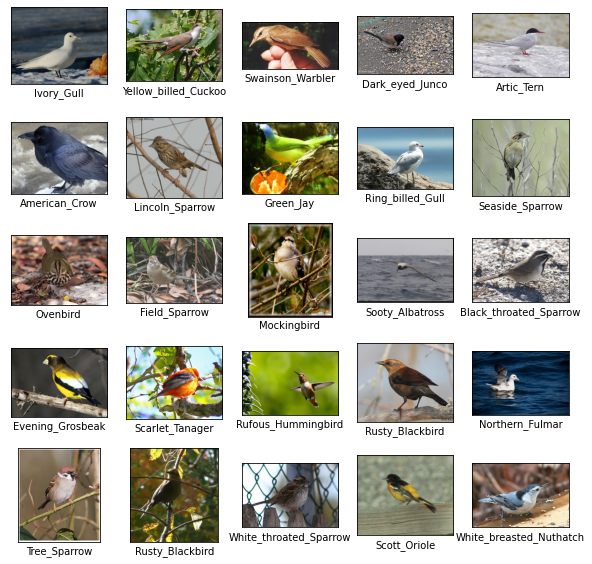

In [21]:
#testing imported data
print(data.images)
print(data.classes)
print(data.image_class_labels)
print(data.bounding_boxes)
print(data.train_test_split)
plot_grid_imgs(data.images.image_id)


# Data processing

In [22]:

# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)


heights = []
widths = []
def get_dims():
  for img_id in tq.tqdm(data.images.image_id):
    img = get_cv2_image(img_id)
    height, width, channels = img.shape
    heights.append(height)
    widths.append(height)
def show_dims():
  print(min(heights))
  print(min(widths))
  print(Average(heights))
  print(Average(widths))
#get_dims()
#show_dims()

In [23]:
def bound_image(img_id):
    img = get_cv2_image(img_id)
    bounding_box = get_bounding_box(img_id)
    #print(img_id,bounding_box)
    x = bounding_box.x.values[0]
    y = bounding_box.y.values[0]
    w = bounding_box.width.values[0]
    h = bounding_box.height.values[0]
    max_dim = max(w, h)
    w_diff = math.floor((w - max_dim)/2)
    h_diff = math.floor((h - max_dim)/2)
    x_srt = x+w_diff
    x_end = x+max_dim
    y_srt = y+h_diff
    y_end = y+max_dim
    if x_srt < 0:
      x_srt = x_srt - x_srt
      x_end = x_end - x_srt
    if y_srt < 0:
      y_srt = x_srt - x_srt
      y_end = x_end - x_srt
    #print(x_srt,x_end,y_srt,y_end)
    crop_img = img[y_srt:y_end,x_srt:x_end] #crops the image with respect to bounding boxes mentioned in the dataset
    return crop_img

def bound_images(image_ids, image_size):
    for img_id in tq.tqdm(image_ids):
        new_path = get_image_path(img_id,bound_fldr)
        #check if already processed
        if check_create_image_loc(new_path):
          cur_img = bound_image(img_id)
          cv2.imwrite(new_path ,cur_img)


bound_images(data.images.image_id, image_size)

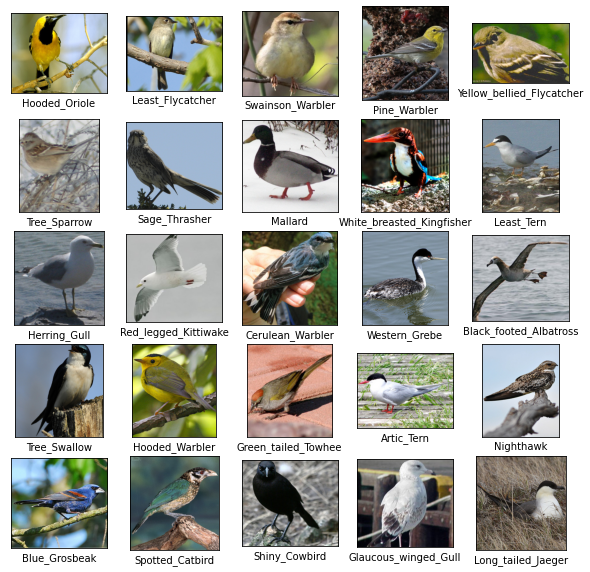

In [24]:
plot_grid_imgs(data.images.image_id, [bound_fldr])

# preprocessing

In [30]:
#Add random noise (actually, randomly change the gray value of pixels on the image to 255, which is white)
def random_noise(img_id,noise_num):
    img = get_cv2_image(img_id,flags=cv2.IMREAD_COLOR,fldr=bound_fldr)
    img_noise = img
    rows, cols, chn = img_noise.shape
    for i in range(noise_num):
        x = np.random.randint(0, rows)
        y = np.random.randint(0, cols)
        img_noise[x, y, :] = 255
    return img_noise

def gamma_transform(img_id):
    img = get_cv2_image(img_id,flags=cv2.IMREAD_GRAYSCALE,fldr=bound_fldr)
    fi = img / 255.0
    gamma = 0.4
    out_img = np.power(fi, gamma)
    return out_img

def pic_transpose(img_id):
    img = get_image(img_id,fldr=bound_fldr)
    #transpose_img = img.transpose(Image.ROTATE_90)
    transpose_img = img.transpose(Image.ROTATE_180)
    #transpose_img = img.transpose(Image.ROTATE_270)
    return transpose_img

def get_imghist(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([img],[0],None,[256],[0,255])
    return hist

def cal_equalhist(img_id):
    img=get_cv2_image(img_id,fldr=bound_fldr)
    if len(img.shape) == 3:
         img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    h,w = img.shape[:2]
    grathist = get_imghist(img)
 
    zerosumMoment = np.zeros([256],np.uint32)
    for p in range(256):
        if p ==0:
            zerosumMoment[p] = grathist[0]
        else:
            zerosumMoment[p] = zerosumMoment[p-1] +grathist[p]
 
    output_q = np.zeros([256],np.uint8)
    cofficient = 256.0/(h*w)
    for p in range(256):
        q = cofficient *float(zerosumMoment[p]) - 1
        if q >= 0:
            output_q[p] = math.floor(q)
        else:
            output_q[p] = 0
 
    equalhistimage = np.zeros(img.shape,np.uint8)
    for i in range(h):
        for j in range(w):
            equalhistimage[i][j] = output_q[img[i][j]]
    return equalhistimage

#bound_fldr = process_fldr + 'bound/'
#noise_fldr = process_fldr + 'noise/'
#gamma_fldr = process_fldr + 'gamma/'
#transpose_fldr = process_fldr + 'transpose/'
#equalhist_fldr =  process_fldr + 'equalhist/'


def preprocess_images(image_ids):
  for img_id in tq.tqdm(image_ids):
    noise_path = get_image_path(img_id,noise_fldr)
    if check_create_image_loc(noise_path):
      noise_img = random_noise(img_id,3000)
      cv2.imwrite(noise_path, noise_img)
    
    gamma_path = get_image_path(img_id,gamma_fldr)
    if check_create_image_loc(gamma_path):
      gamma_img = gamma_transform(img_id)
      cv2.imwrite(gamma_path,gamma_img)
    
    transpose_path = get_image_path(img_id,transpose_fldr)
    if check_create_image_loc(transpose_path):
      transpose_img = pic_transpose(img_id)
      transpose_img.save(transpose_path)

    equalhist_path = get_image_path(img_id,equalhist_fldr)
    if check_create_image_loc(equalhist_path):
      equalhist_img = cal_equalhist(img_id)
      cv2.imwrite(equalhist_path,equalhist_img)

preprocess_images(data.images.image_id)

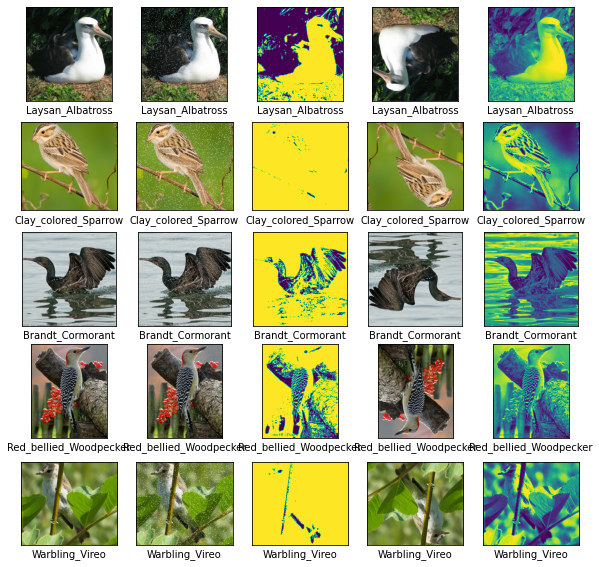

In [31]:
plot_grid_imgs(data.images.image_id, [bound_fldr, noise_fldr, gamma_fldr, transpose_fldr, equalhist_fldr])